In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

In [24]:
cols=['mpg', 'cylinders', 'displacement', 'horsepower','weight','acceleration', 'model year', 'origin','car name']
df = pd.read_csv("data/auto-mpg.data", delim_whitespace=True, names=cols)
df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4200\2307928382.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("data/auto-mpg.data", delim_whitespace=True, names=cols)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


la columna horsepower tiene valores "?" como string en lugar de NaN

In [ ]:
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

# Verificamos cuántos NaN quedaron
print("Valores NaN en horsepower:", df["horsepower"].isna().sum())
print(df["horsepower"].head(10))


Valores NaN en horsepower: 6
0    130.0
1    165.0
2    150.0
3    150.0
4    140.0
5    198.0
6    220.0
7    215.0
8    225.0
9    190.0
Name: horsepower, dtype: float64


### One-Hot Encoding a origin (actualmente esta como: USA=1 , Europe=2 , Japan=3) e imputacion a horsepower

Haremos un preprocessor que: 
(1) imputa medianas en numéricas
(2) estandariza numéricas (media 0, var 1)
(3) pasa dummies “en crudo”

SimpleImputer(strategy="median") → rellena huecos en numéricas (ej: horsepower con “?”).

StandardScaler() → escala numéricas (para GD y regularización).

OneHotEncoder(drop="first") → convierte origin en dos columnas (Europe y Japan), dejando USA como base.

ColumnTransformer → aplica una cosa a las numéricas y otra a las categóricas.

Pipeline → une pasos de preprocesamiento y asegura que se apliquen igual en train y validación.

In [ ]:
y = df["mpg"].values # Variable objetivo
X = df.drop(columns=["mpg", "car name"]) # quitamos car_name porque no aporta al modelo

# Columnas numéricas y categóricas
num_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"]
cat_cols = ["origin"]  # la vamos a codificar

# Pipeline para numéricas (imputar + escalar)
numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

# Pipeline para categóricas (OneHot)
categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),  # por si acaso hay NaN
    ("oh", OneHotEncoder(drop="first"))  # drop="first" evita colinealidad
])

# Preprocesador general
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


Variables estimadoras

Objetivo (y): mpg /
Estimadoras (X) típicas y útiles:

 - Numéricas continuas: cylinders, displacement, horsepower, weight, acceleration, model_year.
 
 - Dummies de origin: las columnas que quedaron tras el one-hot 

### dividimos en train/val (80/20) y usamos un diccionario de decisiones 

In [ ]:
diccionario = {
    "objetivo": "mpg",
    "variables_excluidas": ["car_name"],
    "imputacion_numericas": "median", # robusta a outliers
    "escalado": "StandardScaler (media 0, varianza 1)",
    "codificacion_categoricas": "OneHotEncoder(drop='first') para origin",
    "test_size": 0.20,  # 20% validación
    "train_size": 0.80,
    "random_state": 42, # reproducibilidad
    "razon_split": "80/20 mantiene suficiente data para entrenar y reserva un bloque para validar sin sesgo"
}

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=diccionario["test_size"],
    random_state=diccionario["random_state"]
)

print("Tamaño train:", X_train.shape, " | Tamaño val:", X_val.shape)


Tamaño train: (318, 7)  | Tamaño val: (80, 7)


## Modelo 1: Ecuación Normal (OLS)

$\hat{\beta} = (X^\top X)^{-1} X^\top y$

In [ ]:
# Transformamos los datos con el preprocesador
Xtr = preprocessor.fit_transform(X_train)  # fit en train
Xva = preprocessor.transform(X_val)        # transform en val (sin refit)

# Función para agregar columna de 1 (intercepto)
def add_bias(A):
    return np.c_[np.ones((A.shape[0], 1)), A]

Xtr_b = add_bias(Xtr)
Xva_b = add_bias(Xva)

# Ecuación normal con pseudo-inversa
beta_hat = np.linalg.pinv(Xtr_b.T @ Xtr_b) @ (Xtr_b.T @ y_train.reshape(-1,1))

# Predicciones
ytr_pred = Xtr_b @ beta_hat
yva_pred = Xva_b @ beta_hat

# Métricas de evaluación
def report(y_true, y_pred, nombre):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    r2   = r2_score(y_true, y_pred)
    print(f"{nombre} -> MSE: {mse:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

report(y_train, ytr_pred.ravel(), "OLS (Normal Eq) - Train")
report(y_val,   yva_pred.ravel(), "OLS (Normal Eq) - Val")


OLS (Normal Eq) - Train -> MSE: 11.355 | RMSE: 3.370 | R²: 0.819
OLS (Normal Eq) - Val -> MSE: 8.339 | RMSE: 2.888 | R²: 0.845


## Modelo 2: scikit-learn

In [ ]:
# métricas
def report(y_true, y_pred, nombre):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    r2   = r2_score(y_true, y_pred)
    print(f"{nombre} -> MSE: {mse:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")


### LinearRegression

In [ ]:
ols = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])
ols.fit(X_train, y_train)

report(y_train, ols.predict(X_train), "OLS (sklearn) - Train")
report(y_val,   ols.predict(X_val),   "OLS (sklearn) - Val")


OLS (sklearn) - Train -> MSE: 11.355 | RMSE: 3.370 | R²: 0.819
OLS (sklearn) - Val -> MSE: 8.339 | RMSE: 2.888 | R²: 0.845


### regularización Ridge

In [ ]:
ridge = Pipeline([
    ("prep", preprocessor),
    ("model", Ridge(random_state=42))
])

param_ridge = {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, param_grid=param_ridge, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)

best_ridge = ridge_cv.best_estimator_
print("Mejor alpha Ridge:", ridge_cv.best_params_)

report(y_train, best_ridge.predict(X_train), "Ridge - Train")
report(y_val,   best_ridge.predict(X_val),   "Ridge - Val")


Mejor alpha Ridge: {'model__alpha': 1}
Ridge - Train -> MSE: 11.364 | RMSE: 3.371 | R²: 0.819
Ridge - Val -> MSE: 8.348 | RMSE: 2.889 | R²: 0.845


### regularización Lasso

In [ ]:
lasso = Pipeline([
    ("prep", preprocessor),
    ("model", Lasso(max_iter=10000, random_state=42))
])

param_lasso = {"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, param_grid=param_lasso, cv=5, scoring="neg_mean_squared_error")
lasso_cv.fit(X_train, y_train)

best_lasso = lasso_cv.best_estimator_
print("Mejor alpha Lasso:", lasso_cv.best_params_)

report(y_train, best_lasso.predict(X_train), "Lasso - Train")
report(y_val,   best_lasso.predict(X_val),   "Lasso - Val")


Mejor alpha Lasso: {'model__alpha': 0.01}
Lasso - Train -> MSE: 11.371 | RMSE: 3.372 | R²: 0.819
Lasso - Val -> MSE: 8.433 | RMSE: 2.904 | R²: 0.843


## Modelo 3: Gradiente Descendente

Queremos minimizar el **MSE**:

$J(\beta) = \frac{1}{2n} \sum_{i=1}^n (y_i - X_i \beta)^2$

- **Gradiente**:

$\nabla J(\beta) = \frac{1}{n} X^\top (X\beta - y)$

- **Actualización iterativa**:

$\beta \; \leftarrow \; \beta - \eta \cdot \nabla J(\beta)$


GD - Train -> MSE: 11.365 | RMSE: 3.371 | R²: 0.819
GD - Val -> MSE: 8.414 | RMSE: 2.901 | R²: 0.843


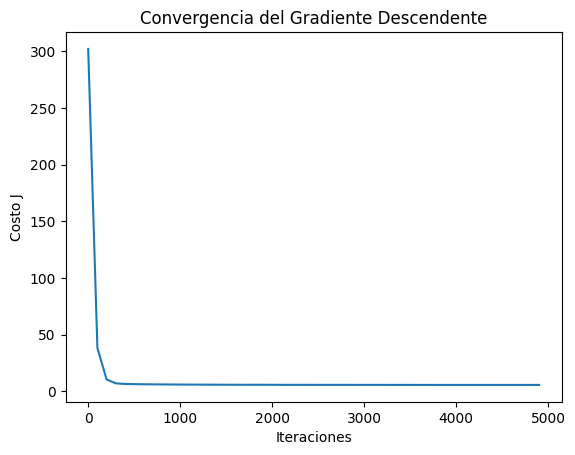

In [ ]:
# Preprocesamiento (fit en train, transform en train y val)
Xtr = preprocessor.fit_transform(X_train)
Xva = preprocessor.transform(X_val)

# Agregamos columna de 1 para el intercepto
def add_bias(A):
    return np.c_[np.ones((A.shape[0], 1)), A]

Xtr_b = add_bias(Xtr)
Xva_b = add_bias(Xva)

# Implementamos Gradiente Descendente
def gradient_descent(X, y, lr=0.01, epochs=5000, tol=1e-8, verbose=False):
    n, p = X.shape
    y = y.reshape(-1,1)
    beta = np.zeros((p,1))  # inicialización
    history = []

    for t in range(epochs):
        # Gradiente
        grad = (1/n) * (X.T @ (X @ beta - y))
        # Actualizacion
        beta_new = beta - lr * grad
        # Guardar costo cada 100 iteraciones
        if t % 100 == 0:
            J = (1/(2*n)) * np.sum((X @ beta_new - y)**2)
            history.append(J)
            if verbose:
                print(f"Iter {t}, Costo J={J:.6f}")
        # Criterio de paro
        if np.linalg.norm(beta_new - beta, ord=2) < tol:
            beta = beta_new
            break
        beta = beta_new

    return beta, history

# Entrenamos con GD
beta_gd, hist = gradient_descent(Xtr_b, y_train, lr=0.01, epochs=5000)

# Predicciones
ytr_pred = (Xtr_b @ beta_gd).ravel()
yva_pred = (Xva_b @ beta_gd).ravel()

# Métricas
def report(y_true, y_pred, nombre):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    r2   = r2_score(y_true, y_pred)
    print(f"{nombre} -> MSE: {mse:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

report(y_train, ytr_pred, "GD - Train")
report(y_val,   yva_pred, "GD - Val")

# Graficamos la curva de costo
plt.plot(range(0, len(hist)*100, 100), hist)
plt.xlabel("Iteraciones")
plt.ylabel("Costo J")
plt.title("Convergencia del Gradiente Descendente")
plt.show()
